Nozomu Nakanishi - 2020264 - Msc DA

# The objectives here are:

## - To create neural networks, at least two and  compare their performance and evaluate what one performed better by using loss as primary and accuracy as the second metrics.

## - Sentiment Analysis using peoples review about culinary recipes on food.com. 

### The reviews a dataset with the score given in stars (from 0/1 to 5) along with the written review. (features that are going to be used.

### Positive / Negative / Neutral Sentimet on the recipes review. 

In [69]:
# The command below is to check where the PySpark is running, 
# in this case (returned:local[*]) data is being processed on my local (personal) machine.

sc.master

'local[*]'

# START ADDING ALL THE LIBRARIES HERE.

In [70]:
from pyspark.sql.functions import count # Funcion to get the "size" of the data.
from pyspark.sql.functions import when # When function.
from pyspark.sql.functions import col # Function column.
from pyspark.sql.functions import mean, min, max, stddev # Imports function for statistical features. 
from pyspark.sql import functions as F # Data processing framework.
from pyspark.sql.functions import lower # lower case function.
from pyspark.sql.functions import length # Import lenght function.
from pyspark.sql.functions import size, split # Imports function size and split.
from pyspark.ml.feature import Tokenizer # Importing Tokenizer.
from pyspark.sql.functions import regexp_replace # Remove / Replace function.
from pyspark.sql.functions import explode, count, desc # Importing for word count.
from pyspark.ml.feature import StopWordsRemover # Imports stopword remover.
from pyspark.sql.types import StructField, StructType # Importing features for Schema.
from pyspark.sql.types import IntegerType, StringType, TimestampType # Tools to create the schema.
from pyspark.sql.functions import udf # Imports function UDF.
from pyspark.sql.types import ArrayType, StringType
import numpy as np # for numerical operations.
import seaborn as sns # Visualization tool.
import matplotlib.pyplot as plt # visualization
%matplotlib inline 

import warnings # Ignore warnings.
warnings.filterwarnings("ignore")

In [73]:
spark = SparkSession.builder.appName('recipe_reviews').getOrCreate()

- The process to achieve the objetive will start importing the recipes reviews dataset and it is composed by 8 features and more than a million rows. The dataset is lincesed under the Creative Commons (CC0 1.0 DEED).

The link for the dataset is available at kaggle: https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews

- There are two datasets in the zip file, however it does not says that the recipe ID in one will match the recipe ID in the other, therefore using only the reviews dataset to achieve the objective.<br>
- Also, two types of format is available, a parquet file and a csv files and the choice for the first one is that the parquet file already has a columnar type, which when taking into consideration the tools that are being used such as pyspark it will present a better speed perfomance when performing tasks. In addition to the reduction for its size in megabytes. 
- The dataset review, which is going to be manipulated, is regarding the written reviews along with score rating given. <b>They are the most important features in  the dataset, in which the rating score would define the positive, neutral and negative label for the sentiment analysis of the review. </b>

## 1. Data preparation and EDA
- Challeging to separete, both will be performed back and forth. 

### - Importing the Review dataset.

First, the dataset will be imported in parquet format as cited above.

In [74]:
# Imports the dataset in a parquet format.
df_reviews = spark.read.parquet("file:///home/hduser/Downloads/Dataset CA1/reviews.parquet")

- After applying .head and .show, the second presented a better layout to look at the columns and the first 10 rows.

In [76]:
# It shows the first ten observations.
df_reviews.show(10)

+--------+--------+--------+----------------+------+--------------------+-------------------+-------------------+
|ReviewId|RecipeId|AuthorId|      AuthorName|Rating|              Review|      DateSubmitted|       DateModified|
+--------+--------+--------+----------------+------+--------------------+-------------------+-------------------+
|       2|     992|    2008|       gayg msft|     5|better than any y...|2000-01-25 21:44:00|2000-01-25 21:44:00|
|       7|    4384|    1634|   Bill Hilbrich|     4|I cut back on the...|2001-10-17 17:49:59|2001-10-17 17:49:59|
|       9|    4523|    2046|Gay Gilmore ckpt|     2|i think i did som...|2000-02-25 09:00:00|2000-02-25 09:00:00|
|      13|    7435|    1773|   Malarkey Test|     5|easily the best i...|2000-03-13 21:15:00|2000-03-13 21:15:00|
|      14|      44|    2085|      Tony Small|     5|  An excellent dish.|2000-03-28 13:51:00|2000-03-28 13:51:00|
|      17|    5221|    2046|Gay Gilmore ckpt|     4|love it, but with...|2000-05-08 12:0

In [ ]:
# Prints the Schema of the dataset.
df_reviews.printSchema()

- The parquet format file already had a schema, therefore keeping the original dataset schema. However, if the csv were to be handled the following code would be appropriate to apply the schema, including the column names along with the data type.

In [6]:
# Code that would be used to apply the schema in the review dataset if was required.

#schema_reviews = StructType([
    #StructField('ReviewId', IntegerType(), True),
    #StructField('RecipeId', IntegerType(), True),
    #StructField('AuthorId', IntegerType(), True),
    #StructField('AuthorName', StringType(), True),
    #StructField('Rating', IntegerType(), True),
    #StructField('Review', StringType(), True),
    #StructField('DateSubmitted', TimestampType(), True),
    #StructField('DateModified', TimestampType(), True)])

The library Pandas used in the previous semester had different set of functions and/or commands. For example, the shape which provided the number of columns and observations in the dataset. However, in the PySpark the count method is use to tell how many rows and the lenght of the columns for the number of features. 
<br>However, in a later stage pandas format will be used for visualization purpose only, because pandas visualizations are better than the pyspark.

In [77]:
num_rows_reviews = df_reviews.count() # Counting the number of rows.
num_columns_reviews =len(df_reviews.columns) # Length of columns.
print(f"Shape: ({num_rows_reviews}, {num_columns_reviews})") # Prints the shape of the dataset.

Shape: (1401982, 8)


- Temporal analysis is not the focus of the project, therefore, the date submitted and modified will be dropped in an early stage.

In [78]:
# Droping two columns of the dataset.
df_reviews = df_reviews.drop("DateSubmitted", "DateModified")

In [79]:
# The three codes below are searching and printing the number of missing values in Review, Rating, Recipe Id.

missing_review = df_reviews.filter(df_reviews.Review.isNull())
print(f"Number of observations with missing Review: {missing_review.count()}")

missing_rating = df_reviews.filter(df_reviews.Rating.isNull())
print(f"Number of observations with missing Rating: {missing_rating.count()}")

missing_recipeid = df_reviews.filter(df_reviews.RecipeId.isNull())
print(f"Number of observations with missing Recipe Id: {missing_recipeid.count()}")

Number of observations with missing Review: 0
Number of observations with missing Rating: 0
Number of observations with missing Recipe Id: 0


- No missing values are recorded in the Recipe Id and Review, Ratings.

Regarding the frequency, three features will be analysed, the Rating scores (check which score have the highest number and the lowest), the RecipeId (check how many times that recipe recieved a review and the AuthorId (check how many times that author wrote a review).

In [80]:
# The codes below are getting the frequency of values using the count function and printing them from
# the highest to the lowest.

df_reviews.groupBy("Rating").count().orderBy("Rating").show()
print(f"Frequency of Ratings")

df_reviews.groupBy("RecipeId").count().orderBy("count", ascending=False).show(20)
print(f"Frequency of RecipesId")

df_reviews.groupBy("AuthorId").count().orderBy("count", ascending=False).show(20)
print(f"Frequency of AuthorId")

+------+-------+
|Rating|  count|
+------+-------+
|     0|  76248|
|     1|  16559|
|     2|  17597|
|     3|  50279|
|     4| 229217|
|     5|1012082|
+------+-------+

Frequency of Ratings


+--------+-----+
|RecipeId|count|
+--------+-----+
|   45809| 2892|
|    2886| 2182|
|   27208| 1614|
|   89204| 1584|
|   39087| 1491|
|   67256| 1359|
|   35813| 1353|
|   54257| 1325|
|   22782| 1273|
|   32204| 1228|
|  420398| 1174|
|   25690| 1076|
|   69173| 1023|
|   73440| 1008|
|   68955|  910|
|   33919|  885|
|   82102|  862|
|   25885|  856|
|   85629|  805|
|   28148|  804|
+--------+-----+
only showing top 20 rows

Frequency of RecipesId


+--------+-----+
|AuthorId|count|
+--------+-----+
|  424680| 8842|
|   37449| 6605|
|  383346| 5438|
|  128473| 4693|
|  169430| 4586|
|   89831| 3963|
|   58104| 3743|
|  199848| 3688|
|  133174| 3590|
|  305531| 3543|
|  226863| 3340|
|    4470| 3260|
|  369715| 3167|
|  498271| 3014|
| 1072593| 2810|
|  176615| 2790|
|   95743| 2664|
|  286566| 2635|
|  107583| 2588|
|   88099| 2574|
+--------+-----+
only showing top 20 rows

Frequency of AuthorId


The Recipes and AuthorId column:
- The recipes that recieved the highest amount of reviews was with the ID of 45089 and 2886 (more than 2000 ratings);
- The Author that most reviewed recipes on the website was the Id424680 with 8842, followed by Id37449 with 6605 reviews;

In [81]:
# Checking if the same user (AuthorId) posted more than one review in a recipe (RecipeId).
# Since both columns are integers, the group by and aggregation will be used to find it.

# Grouping the Author and Recipe Id and count the occurrences.
dd_review = df_reviews.groupBy("AuthorId", "RecipeId").agg(F.count("*").alias("num_reviews"))
# Filtering rows where the count is above 1, which can indicate that the recipe multiple review from the same user.
dd_review = dd_review.filter(dd_review.num_reviews > 1)
# Displaying the results.
dd_review.show()

+--------+--------+-----------+
|AuthorId|RecipeId|num_reviews|
+--------+--------+-----------+
+--------+--------+-----------+



Based on the empty results provided by the previous line of code, no users posted a review more than once in the same recipe. 

- Only displaying the statistical features of the rating score, which is the only column that is going to be used in the analysis. The review and author Id columns are mainly to identify which is the review and who gave it.

In [82]:
# Displaying statistical features of the Reviews dataset.
df_reviews.describe().select("summary", "Rating").show()

+-------+------------------+
|summary|            Rating|
+-------+------------------+
|  count|           1401982|
|   mean| 4.407951029328479|
| stddev|1.2720116809642992|
|    min|                 0|
|    max|                 5|
+-------+------------------+



Based on missing value and statistical feature codes, there are no missing values on the reviews dataset (same count as the shape of the dataset). And some statistical features can be displayed:
- It has a range of scores between 0 and 5;
- The mean of 4.4 is close to 5, therefore most of the data points are close the highest value, so the data present signs of being left-skewed (strong evidence for skewness);
- Also, because most of the values a concentrated in the score 5, the box (boxplot) might be very close or at the top at the upper whisker.
- It presents a high standard deviation given the range of the scores.

Further analysis will be performed next using visual tools.

### Ratings feature visual representation.

- The visualization tools using Pandas provided a better result, therefore for visualization purpose it will be created a dataframe using pandas library.

In [83]:
# Creating a dataframe using pandas library.
ratings_column_pd = df_reviews.select("Rating").toPandas()

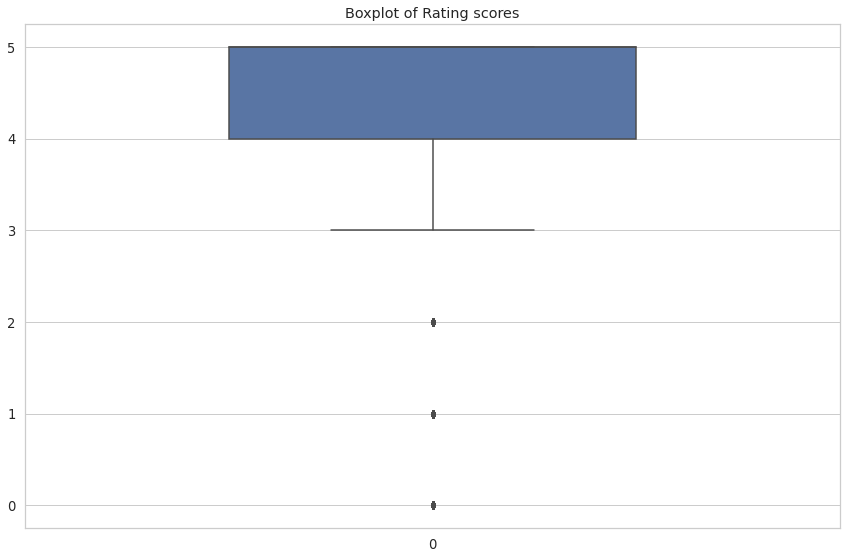

In [84]:
# Generating the figure.
plt.figure(figsize=(12, 8)) # Setting the figure size.
sns.set(style="whitegrid", font_scale=1.2) # Addind a white space on the back and adjustive font scale.
# Creates the boxplot
ax = sns.boxplot(data=ratings_column_pd['Rating'], width=0.5) # Boxplot, setting the width of the box to .5.
ax.set_title('Boxplot of Rating scores') # Add title to the figure.
plt.tight_layout() # Adjusts the layout
plt.show() # Shows the plot

The boxplot shows shows that most of values are located in the maximum values, but also points the score 0, 1 and 2 as outliers, this could be due to the fact that those values represents a small percentage of the total (approximately 7-8%). So based on IQR calculations are considering them as outliers.

- The values 1 and 2 will not be outliers, despite being a small amount they represent negative score reviews of the recipe;
- The value of 0 will be analysed in a later stage along with the writen review.

Despite the outliers considerations the values which represents the 1 and 2 score rating will remain in the dataset. This is because they are still a valid data point. Although, the score zeros will be analysed a little further.

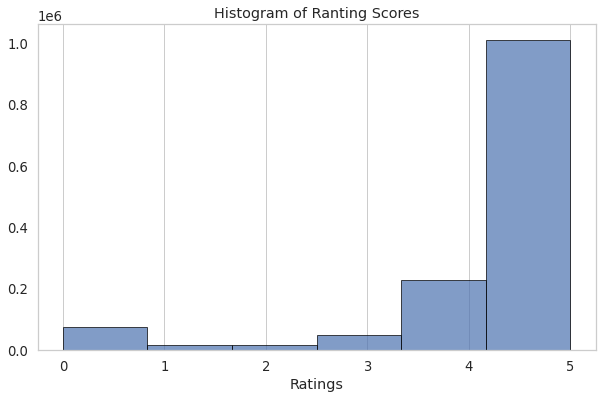

In [85]:
# Creating the figure for the histogram.
plt.figure(figsize=(10, 6))
# Plots the histogram, bins set at 6 because of the range of the value.
plt.hist(ratings_column_pd['Rating'], bins=6, edgecolor='black', alpha=0.7)
plt.title("Histogram of Ranting Scores") # Sets title.
plt.xlabel("Ratings") # Sets x label.
plt.xticks(range(6)) # Add ticks with range between 0 and 6.
plt.grid(axis='y') 
plt.show() # Display the histogram.

The histogram shows that the ratings scores data is highly left skewed. With most of its values located at the maximum.

- The score zero raised doubts if someone forgot to leave a score or if it is actually the worst score.

- Also, there are no notes about the score zero, so a manual check will be apply to check if there is a balance between the review and the score zero. The procedure will be done by looking at random samples (attempted multiple times with differend seed values), checking if the reviews truly represents a sentiment of a lowest score possible.

In [86]:
zero_reviews = df_reviews.filter(col("Rating") == 0)
sample_reviews = zero_reviews.sample(withReplacement=False, fraction=0.25, seed=70)
sample_reviews.select("Review").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Review                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

- According to last code (with many attempts using different seed numbers), the written reviews does not match the score zero given. Positives reviews such as, great recipe, its delicious . Therefore, the chosen option is to drop the 0 scores (anomalies), so it does not affects the analysis by introducing noise to it, increasing the consistency in the data.
- And since they are anomalies in the data, the rows with score of 0 will be dropped, also saving computational resources. 
<br><br><br>The next two codes will be used to drop (by using the method filter) and after printing the counts before and after the operation to check if it was correct. 

In [87]:
# Method filter to exclude the rows with Rating equal to zero.
df_reviews_no_zero = df_reviews.filter(df_reviews.Rating != 0)

In [88]:
# Counting observations before and after the exclusion and printing them for verification. 
original_count = df_reviews.count()
filtered_count = df_reviews_no_zero.count()
print(f"Original obs count: {original_count}")
print(f"After filter obs count: {filtered_count}")

Original obs count: 1401982
After filter obs count: 1325734


- After the drop, the observations reduced by 76248, which is the number of zero scores given (also provided at the frequency line of code). Therefore, the drop operation was sucessful.

In [89]:
# Calculating the distribution of scores and the three different groups.
# Placing the 1,2 to the negatives, 3 neutral and 4,5 positives.
class_counts = (
    df_reviews_no_zero.withColumn(
    "Rating_class",
    when((df_reviews_no_zero['Rating'] >= 1) & (df_reviews_no_zero['Rating'] <= 2), "Negatives (1-2)")
    .when(df_reviews_no_zero['Rating'] == 3, "Neutral (3)")
    .otherwise("Positives (4-5)"))
# Grouping the ratings into its class and using rdd to transform them into a dictionary which is easier to access in a query.
    .groupBy("Rating_class")
    .count()
    .rdd.collectAsMap())

# Calculates to total number of reviews.
total_reviews = sum(class_counts.values())
# Calculates the ratio.
Ratios = {k: v / total_reviews for k, v in class_counts.items()}
# Prints the percentages.
for Rating_class, ratio in Ratios.items():
    print(f"Rating Class {Rating_class}: {ratio*100:2f}%")

Rating Class Neutral (3): 3.792541%
Rating Class Negatives (1-2): 2.576384%
Rating Class Positives (4-5): 93.631075%


Through the last line of code, the Rating column:

- By far, the highest number of score given is the value of 5 (maximum);
- Lower scores (1 , 2) represents less than 3% of the total of ratings given and less than 4% for neutral scores (3);
- The imbalance between the positive classes are enourmous considering the others, and this potenlially could add bias into the sentiment analysis. To address this issue there are some options available to and a mixed between oversampling and undersampling will be performed after the dataframe is split into train and test. 


### Next stage will be the text processing of the Review column follow by the steps above: 

- Label definition; 
- Lowering case; 
- Removing punctuations and \r\n;
- Tokenization;
- Removing Stop Words;
- Filtering out short tokens;
- Lemmatization;
- Word2Vec;

### Text Processing of the Review Column for Sentiment Analysis

To start, a column (label) will be created with positive, negativa and neutral labels according to the rating score given by the reviewer. 

In [90]:
# Creates a new column 'label' based on rating values
df_reviews_no_zero = df_reviews_no_zero.withColumn("label", 
                   when(col("rating").isin([1, 2]), "negative")
                   .when(col("rating") == 3, "neutral")
                   .otherwise("positive")
                  )

# You can verify by showing a few records
df_reviews_no_zero.select("rating", "label").show()


+------+--------+
|rating|   label|
+------+--------+
|     5|positive|
|     4|positive|
|     2|negative|
|     5|positive|
|     5|positive|
|     4|positive|
|     5|positive|
|     5|positive|
|     5|positive|
|     4|positive|
|     5|positive|
|     5|positive|
|     1|negative|
|     5|positive|
|     4|positive|
|     1|negative|
|     5|positive|
|     5|positive|
|     3| neutral|
|     4|positive|
+------+--------+
only showing top 20 rows



In [91]:
# Creating a column named Review_lower to the dataframe in a lowercase version.
process_reviews = df_reviews_no_zero.withColumn("Review_lower", lower(col("Review")))

In [92]:
# Looks for any observation that the transformation did not work.
no_match = process_reviews.filter(lower(col("Review")) !=col("Review_lower")).count()

if no_match == 0:
    print("Transformation successful.")
else:
    print("There is/are rows that the transformation did not work.")

Transformation successful.


- After the transformation, a few statistical features will be generated for comparison purpose. 

In [93]:
# Displaying the characters length of the review_lowercase column
process_reviews = process_reviews.withColumn("rev_char_length", length(process_reviews["Review_lower"]))
process_reviews.select("rev_char_length").show()

+---------------+
|rev_char_length|
+---------------+
|             44|
|            102|
|             91|
|            119|
|             18|
|             38|
|            108|
|             26|
|            106|
|             48|
|            118|
|            182|
|             27|
|            167|
|            146|
|             10|
|            339|
|             83|
|             65|
|            225|
+---------------+
only showing top 20 rows



In [94]:
# Displaying statistical feature of the reviews character length. 
process_reviews.select("rev_char_length").describe().show()

+-------+------------------+
|summary|   rev_char_length|
+-------+------------------+
|  count|           1325734|
|   mean| 276.9054689703968|
| stddev|194.79580324070147|
|    min|                 0|
|    max|              8587|
+-------+------------------+



In [95]:
# Transforming to pandas dataframe for visualization purpose.
review_char_lengh_pd = process_reviews.select("rev_char_length").toPandas()

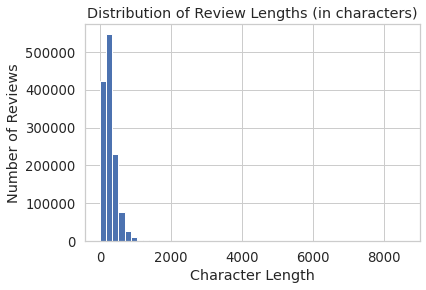

In [96]:
# Creating histogram for characters length
char_lengths = review_char_lengh_pd["rev_char_length"] # Data
char_lengths.hist(bins=50) # Generate histogram.
plt.xlabel("Character Length") # Adds label.
plt.ylabel("Number of Reviews") # Adds label.
plt.title("Distribution of Review Lengths (in characters)") # Adds title.
plt.show() # Shows the histogram.

- According to the character length histogram, the majority of reviews ranges between 0 and around 1500. But also showing that also has reviews with more than 6000 characters. 

In [97]:
w_count = process_reviews.withColumn("word_count", size(split(process_reviews["Review_lower"], " ")))

w_count.select("word_count").describe().show()

+-------+-----------------+
|summary|       word_count|
+-------+-----------------+
|  count|          1325734|
|   mean|53.35392393949314|
| stddev|37.57547429823871|
|    min|                1|
|    max|             1184|
+-------+-----------------+



- Before applying tokenization, a few statistical feature will be extract to check for any differences before and after transformations during the text processing.And beginning with the descriptive statistics of the review feature has 1325734 rows, with an average around 53 words in each review, ranging from 1 to more than 1000 words.

The following step is to remove punctuations and other special characters from the text.

In [98]:
# Removing punctions of the Review_lowercase column.
process_reviews = process_reviews.withColumn("Review_no_punct", regexp_replace(col("Review_lower"), "[^a-zA-Z\s]", ""))

In [99]:
# Displays the rows of column before and after the removal of punctuations. 
process_reviews.select("Review_lower", "Review_no_punct").show(n=20, truncate=False)   

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Review_lower                                                                                                                                                                                                                                                                                                               

- The previous line of code shows that the removal of puctuations was successful. However, it shows special characters like \r\n, which will be removed in the following step.

In [100]:
# Removing \r\n.
process_reviews = process_reviews.withColumn("Review_no_punct2", regexp_replace(col("Review_no_punct"), "[\r\n]", ""))

In [101]:
process_reviews.select("Review_no_punct", "Review_no_punct2").show(n=20, truncate=False)  

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Review_no_punct                                                                                                                                                                                                                                                                                                                            |Review_no_punct2     

- The previous code shows that the characters like \r\n were erased. 

The next step will tokenize the review column, transforming each word in tokens.

In [102]:
# Creating tokenizer with the column tokens as output.
tokenizer = Tokenizer(inputCol="Review_no_punct2", outputCol="tokens")

In [103]:
# Apply the transformation.
token_reviews = tokenizer.transform(process_reviews)

In [104]:
# It "explodes" the tokens column to have one token per row.
#df_exploded = token_reviews.select(explode("tokens").alias("word"))

# Groups individual by tokens and count their occurrences.
#word_counts = df_exploded.groupBy("word").agg(count("word").alias("count"))

# Orders by count in descending order to see most frequent words at the top.
#word_counts_ordered = word_counts.orderBy(desc("count"))

# Show the results.
#word_counts_ordered.show()

+------+-------+
|  word|  count|
+------+-------+
|      |3279768|
|     i|3108489|
|   the|3018518|
|   and|2329822|
|     a|1804978|
|    it|1607492|
|  this|1412254|
|    to|1381135|
|   for|1316394|
|    of|1140789|
|   was| 954028|
|recipe| 789514|
|    in| 657126|
|    my| 629697|
|  with| 628741|
|    is| 588018|
|  made| 560845|
|    so| 556641|
|  used| 498798|
|   but| 477474|
+------+-------+
only showing top 20 rows



- After separating into words, it was identified that blank spaces, i and the are the most common tokens (more than 3 million each).

In [105]:
# Selecting and displaying two columns, to check the results of the operation.
token_reviews.select("Review_no_punct2", "tokens").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Review_no_punct2                                                                                                                                                                                                                                                                                                       |t

- The last cell shows how the words were separeted after tokenizing them. (they are separeted by commas)

In [107]:
w_t_count = token_reviews.withColumn("word_count_punct", size(token_reviews["tokens"]))

w_t_count.select("word_count_punct").describe().show()

+-------+-----------------+
|summary| word_count_punct|
+-------+-----------------+
|  count|          1325734|
|   mean|53.22485279852519|
| stddev|37.54565917289778|
|    min|                0|
|    max|             1184|
+-------+-----------------+



In [108]:
token_reviews.filter(size(token_reviews["tokens"]) == 0).count()

4

- After the tokenization the length of words, so as the the standard deviation did not change. However, the transformation mande some of the observation to become zero. The cells with review zero will be dealt with in the following steps.

#### Removing Stop Words.

In [109]:
# Creating a stopword remover with tokens as an input column and filtered_tokens as an output.
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")

In [110]:
# Removes stopwords by creating an output called filtered reviews.
token_reviews = remover.transform(token_reviews)

In [111]:
# Displaying the same features but in different stages to check the operation.
token_reviews.select("Review_no_punct2", "tokens", "filtered_tokens").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Review_no_punct2                                                      

#### Filtering short tokens

- It will remove token with less than 2 characters and the reason why is that in food review the word "no", can have significant impact. For example, "no good" and "good" will be the same, which is not true.
<br><br>The following code will perform the task using UDF:

In [112]:
# UDF to filter out short tokens
filter_short_udf = udf(lambda tokens: [token for token in tokens if len(token) > 1], ArrayType(StringType()))

token_reviews = token_reviews.withColumn("tokens_2", filter_short_udf(token_reviews["filtered_tokens"]))


In [113]:
# Selecting and displaying two columns, to check the results of the operation.
token_reviews.select("filtered_tokens", "tokens_2").show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|filtered_tokens                                                                                                                                                                                                                                   |tokens_2                                                                                                                                                                                                                                  |
+---------------------------------------

In [117]:
token_reviews.filter(size(token_reviews["tokens_2"]) == 0).count()

327

In [119]:
# Filter the empty token reviews
empty_token_reviews = token_reviews.filter(size(token_reviews["tokens_2"]) == 0)

# Group by the 'Rating' column and count the number of reviews in each group
result = empty_token_reviews.groupBy("Rating").agg({"Rating": "count"}).orderBy("Rating")

# Show the result
result.show()


+------+-------------+
|Rating|count(Rating)|
+------+-------------+
|     1|           16|
|     2|            5|
|     3|           11|
|     4|           50|
|     5|          245|
+------+-------------+



- After removing the stop words and filtering out short tokens, the number of observations in the review column with zero tokes increased from 4 to 327, which the amount for each score can be looked at the previous code.

The chosen solution for the empty rows after the transformation is to drop them, performed in the next line of code. 

In [121]:
# Remove rows where the token list is empty
non_empty_reviews = token_reviews.filter(size(token_reviews["tokens_2"]) > 0)

In [123]:
final_count = non_empty_reviews.withColumn("final_count", size(non_empty_reviews["tokens_2"]))

final_count.select("final_count").describe().show()

+-------+------------------+
|summary|       final_count|
+-------+------------------+
|  count|           1325407|
|   mean|26.158801786922808|
| stddev| 18.18721206046169|
|    min|                 1|
|    max|               639|
+-------+------------------+



In [ ]:
# Transforming to pandas dataframe for visualization purpose.
aa = final_count.select("final_count").toPandas()

In [ ]:
# Creating histogram for characters length
char_lengths = raa["final_count"] # Data
char_lengths.hist(bins=50) # Generate histogram.
plt.xlabel("Token Length") # Adds label.
plt.ylabel("Number of Reviews") # Adds label.
plt.title("Distribution of Review Lengths (in tokens)") # Adds title.
plt.show() # Shows the histogram.

The stage of text processing almost at the final stage, the descriptive statistical of the reviews suffered a big change. 
- Started with 1,401,982 rows and at this stage have 1,325,407, a reduction of 76,575.
- The mean of 53 reduced to 26, meaning that the average length of words in each review reduced more than 50%, a big decrease. 
- Standard Deviation, also reduced around 50%.
- The max length also slumped, from more than 1100 words it is now 639.  

In [125]:
import nltk
from nltk.stem import WordNetLemmatizer

# Download wordnet data for nltk
# nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Defining UDF for lemmatization
@udf(ArrayType(StringType()))
def lemmatize_udf(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Apply the UDF
tokens_lemma = non_empty_reviews.withColumn("lemmatized_tokens", lemmatize_udf(token_reviews["tokens_2"]))


In [127]:
from pyspark.ml.feature import Word2Vec

# Initialize word2vec model
word2vec = Word2Vec(vectorSize=100, minCount=5, inputCol="lemmatized_tokens", outputCol="word2vec_features")

# Fit the model on your data
word2vec_model = word2vec.fit(tokens_lemma)

# Transform the data to get word embeddings
df_reviews_w2v = word2vec_model.transform(tokens_lemma)


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
